In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.decomposition import PCA

In [2]:
# Generate correlated features
def generateRandomCovarianceVarianceMatrix(n_features):
    random_matrix = np.random.rand(n_features, n_features)

    # Create a symmetric matrix by taking the average of the matrix and its transpose
    var_cov_matrix = (random_matrix + random_matrix.T) / 2
    
    # Ensure the diagonal elements represent variances (non-negative values)
    var_cov_matrix[np.diag_indices(n_features)] = np.abs(var_cov_matrix[np.diag_indices(n_features)])

    # Ensure positive semidefiniteness
    eigenvalues, eigenvectors = np.linalg.eigh(var_cov_matrix)
    eigenvalues[eigenvalues < 0] = 0  # Replace negative eigenvalues with 0
    var_cov_matrix = np.dot(eigenvectors, np.dot(np.diag(eigenvalues), eigenvectors.T))

    return var_cov_matrix

def generateCorrelatedFeatures(n_features, n_samples, vc_matrix=None):
    if vc_matrix is None:
        vc_matrix = generateRandomCovarianceVarianceMatrix(n_features)
        
    return np.random.multivariate_normal(np.repeat(0, n_features), vc_matrix, size=n_samples)
    

## Illustration of PCA on a simple simulated dataset with 2 correlated features

### Data generation (2 features)

In [3]:
np.random.seed(20240304)

# Generate data
n_samples = 100
n_features = 2
X = generateCorrelatedFeatures(n_features, n_samples)

def f(X):
    return X[:, 0] + X[:, 1]

Y = f(X) + np.random.normal(size=n_samples)

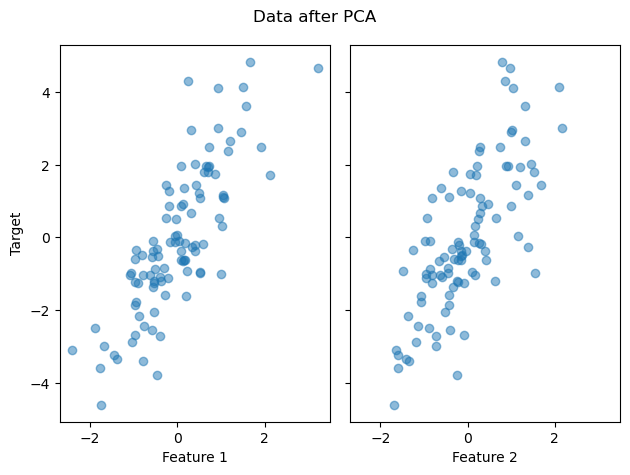

In [4]:
# Plot the original data
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

ax1.scatter(X[:, 0], Y, alpha=0.5)
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Target')

ax2.scatter(X[:, 1], Y, alpha=0.5)
ax2.set_xlabel('Feature 2')

fig.suptitle('Data after PCA')
fig.tight_layout()

### Running PCA (2 features)

We transform the coordinates of the original variables to capture as much
variation as we can with independent (orthogonal) dimensions.
For a very nice illustration and discussion, see [here](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues).


In [5]:
# Apply PCA and calculate the principal components as X_pca
# the PCA is only about X
pca = PCA()
X_pca = pca.fit_transform(X)

### Characteristics of PCA

Recap: We transform the coordinates of the original variables to capture as much variation as we can with independent (orthogonal) dimensions.
For a very nice illustration and discussion, see [this Cross Validated post](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues).


#### Plot principal components

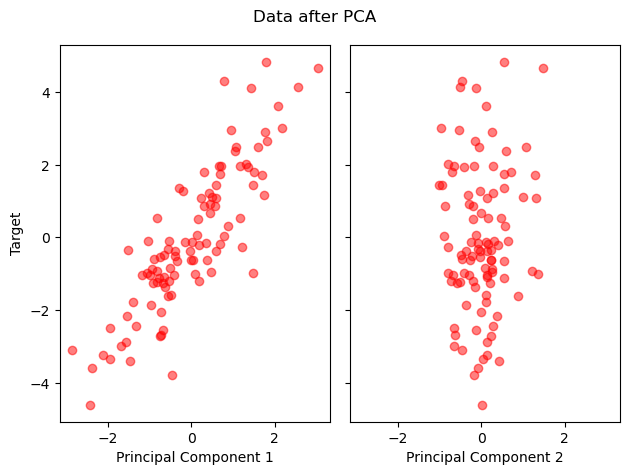

In [6]:
# Plot the PCA-transformed data
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
    
fig.suptitle('Data after PCA')

ax1.scatter(X_pca[:, 0], Y, color='red', alpha=0.5)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Target')

ax2.scatter(X_pca[:, 1], Y, color='red', alpha=0.5)
ax2.set_xlabel('Principal Component 2')

fig.tight_layout()

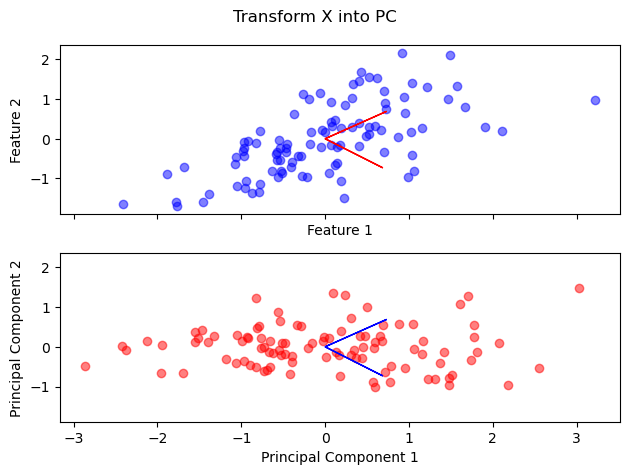

In [7]:
# Compare the space of X to the space of principal components
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
    
fig.suptitle('Transform X into PC')

ax1.scatter(X[:, 0], X[:, 1], color='blue', alpha=0.5)
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

ax1.arrow(0,0,pca.components_[0,0],pca.components_[1,0], color='red')
ax1.arrow(0,0,pca.components_[1,0],pca.components_[1,1], color='red')
# add the principal component transformation vectors to the plot once you know where to get the loadings from


# add a new plot about the transformed features
ax2.scatter(X_pca[:, 0], X_pca[:, 1], color='red', alpha=0.5)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')

ax2.arrow(0,0,pca.components_[0,0],pca.components_[1,0], color='blue')
ax2.arrow(0,0,pca.components_[1,0],pca.components_[1,1], color='blue')

fig.tight_layout()

#### Variance explained

In [8]:
(np.var(X[:,0]), np.var(X[:,1]))

(0.8546596978800847, 0.789082792017864)

In [9]:
(np.var(X_pca[:,0]), np.var(X_pca[:,1]))

(1.3481061483306085, 0.295636341567341)

In [10]:
total_variance_in_features = np.var(X[:, 0]) + np.var(X[:, 1])
total_variance_in_features

1.6437424898979487

In [11]:
pca.explained_variance_
# this shows us that it is a two dimentional awway. the first variance is much larger than the second.
# the goal is to maximize the variance

array([1.36172338, 0.29862257])

In [12]:
pca.explained_variance_ / total_variance_in_features

array([0.82842866, 0.18167235])

In [13]:
pca.explained_variance_ratio_

array([0.82014437, 0.17985563])

In [14]:
print(f'The first principal component explains {round(pca.explained_variance_ratio_[0] * 100, 1)}% of the total variance')

The first principal component explains 82.0% of the total variance


#### Loadings/weights: how to transform the space of X into the space of principal components

In [15]:
pca.components_

array([[ 0.728803  ,  0.68472343],
       [ 0.68472343, -0.728803  ]])

The squared loadings (weights) sum up to 1:

In [16]:
np.sum(pca.components_**2, axis=1)

array([1., 1.])

#### Orthogonality of principal components

Each principal component contains "independent" variance from the data:

In [17]:
sum(pca.components_[:, 0] * pca.components_[:, 1])

0.0

## PCA as regularization (complexity reduction)

### Multivariate model

We work with an "approximately sparse" model: all features matter but to an exponentially decreasing extent.

In [18]:
def generateCoefficients(n_features):
    return [4 / (i + 1)**2 for i in range(n_features)]

def approximatelySparseF(X):
    beta = generateCoefficients(X.shape[1])
    return np.dot(X, beta)

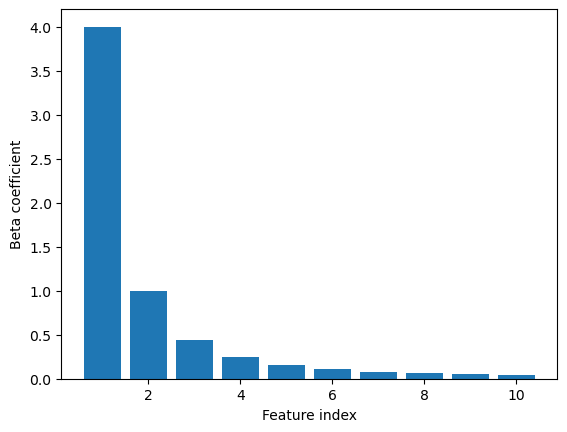

In [19]:
plt.bar([i + 1 for i in range(10)], generateCoefficients(10))
plt.ylabel("Beta coefficient")
plt.xlabel("Feature index")
plt.show()

### Uncorrelated predictors

#### Data generation (uncorrelated predictors)

In [20]:
np.random.seed(20240304)

n_samples = 100
n_features = 40 #lot of features, which is good for machine learning

X_uncorrelated = np.random.normal(0, 1, size=(n_samples, n_features)) # uncorrelated features
Y = approximatelySparseF(X_uncorrelated) + np.random.normal(size=n_samples)

#### Running PCA (uncorrelated predictors)

In [21]:
pca = PCA()
X_pca = pca.fit_transform(X_uncorrelated)

In [22]:
pca.explained_variance_ratio_

array([0.06703083, 0.05634823, 0.05580766, 0.05089322, 0.04879297,
       0.04338137, 0.04237574, 0.04079594, 0.0388622 , 0.03866029,
       0.0354786 , 0.03386725, 0.03196637, 0.03021407, 0.02875075,
       0.02810891, 0.02753165, 0.02464783, 0.02353719, 0.02248769,
       0.020986  , 0.02028345, 0.01993288, 0.01698189, 0.01660667,
       0.01514228, 0.01446192, 0.01389558, 0.01244054, 0.01191888,
       0.00977018, 0.00884056, 0.0084217 , 0.00817128, 0.00727756,
       0.0066    , 0.00581094, 0.00512952, 0.0044551 , 0.0033343 ])

In [23]:
pca95 = PCA(n_components=0.95) # number between 0 and 1, and will represent this percent of the total variance
X_pca95 = pca95.fit_transform(X_uncorrelated)
X_pca95.shape[1]

32

In [24]:
# Another method without the need of creating a new PCA object
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
np.argmax(cumulative_explained_variance > 0.95) + 1

32

In [25]:
print(f'{round(X_pca95.shape[1] / n_features * 100, 1)}% of features explain 95% of the total variance.')

80.0% of features explain 95% of the total variance.


### Correlated predictors

#### Data generation

In [26]:
np.random.seed(20240304)

vc_matrix_fixed = generateRandomCovarianceVarianceMatrix(n_features)
X_correlated = generateCorrelatedFeatures(n_features, n_samples, vc_matrix_fixed)
Y = approximatelySparseF(X_correlated) + np.random.normal(size=n_samples)

#### Running PCA (correlated predictors)

In [27]:
# TODO: run PCA and look at what percentage of the features explain 95%+ of the total variance
pca = PCA()
X_pca = pca.fit_transform(X_correlated)

In [28]:
pca.explained_variance_ratio_

array([4.46366514e-01, 7.17756733e-02, 6.41100202e-02, 6.02351786e-02,
       5.22111782e-02, 4.26012099e-02, 4.03180845e-02, 3.55209834e-02,
       2.88372462e-02, 2.57928853e-02, 2.42520901e-02, 2.17191346e-02,
       1.85668076e-02, 1.76687769e-02, 1.63177750e-02, 1.20725770e-02,
       8.74128317e-03, 6.81381415e-03, 4.05066108e-03, 2.02810682e-03,
       7.56261589e-17, 7.40655595e-17, 6.72739732e-17, 5.84856985e-17,
       5.41556110e-17, 4.66919624e-17, 4.30271024e-17, 4.03461967e-17,
       3.66581960e-17, 3.65581863e-17, 3.25173731e-17, 2.93521177e-17,
       2.62178019e-17, 2.31918652e-17, 1.86815231e-17, 1.66786101e-17,
       1.42659391e-17, 1.22940655e-17, 1.20010921e-17, 8.65569482e-18])

In [29]:
pca95 = PCA(n_components=0.95) # number between 0 and 1, and will represent this percent of the total variance
X_pca95 = pca95.fit_transform(X_correlated)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_pca95 = np.argmax(cumulative_explained_variance > 0.95) + 1

print(f'{X_pca95.shape[1]} features (principal components) are in the transformated dataset')
print(f'{round(X_pca95.shape[1] / n_features * 100, 1)}% of features explain 95% of the total variance.')

15 features (principal components) are in the transformated dataset
37.5% of features explain 95% of the total variance.


### Estimate Y with all variables vs with the first few principal components

#### How to evaluate?

We used to evaluate our models in two different ways:

1. Monte Carlo simulation: generating many different data sets from the same data generation process and evaluating the performance at specific points, using our knowledge of the true outcome (with the irreducible error removed) - we could look at bias, variance and MSE.
2. Train-test split: take a data set and split it into two parts: use the train set to estimate the model and evaluate the performance on the test set (the result includes the irreducible error) - we could look at MSPE only.

Here we take the combination of these two approaches: We generate a 'test set' from the data generation process, and then evaluate the model on this set, using our knowledge of the true outcome (with the irreducible error removed). This allows us to focus on the irreducible part of the error, while still sticking to our one data set. We will look at the MSE.

In [30]:
# Generate test set
X_test = generateCorrelatedFeatures(n_features, n_samples, vc_matrix_fixed)
Y_test = approximatelySparseF(X_test)

#### OLS on all features

In [31]:
from sklearn.linear_model import LinearRegression

linreg_all_features = LinearRegression().fit(X_correlated, Y)
prediction = linreg_all_features.predict(X_test)
mse_all = np.mean((prediction - Y_test)**2)
print(f'The mean squared error (MSE) of the model using all features is: {mse_all}')


The mean squared error (MSE) of the model using all features is: 0.855642958748219


#### OLS on the first few principal components that capture 95% of the variance

In [35]:
#doing an linear regression and fitting it on X_pca
n_pca95 = 15
linreg_pca95 = LinearRegression().fit(X_pca[:,:15], Y)
prediction = linreg_all_features.predict(pca.transform(X_test)[:,:15])
mse_pca95 = np.mean((prediction - Y_test)**2)
mse_pca95

ValueError: X has 15 features, but LinearRegression is expecting 40 features as input.

#### Bias-variance trade-off

In [ ]:
# TODO: Calculate MSE of OLS models by changing how many principal components is used
mse_results = []
for i in range(n_features):
    n_pc = i + 1
    # estimate linear regression
    # predict on X_test (do not forget to use the PC-s on X_test instead of the original features)
    # calculate MSE as mse_pca
    mse_results.append(mse_pca)

In [ ]:
# Chart
plt.plot([i + 1 for i in range(n_features)], mse_results)
plt.xlabel('Number of principal components')
plt.ylabel('MSE')
plt.title('Bias-variance trade-off in Principal Component Regression')
plt.show()

#### How would LASSO perform on this task?

Try it out at home ;)

## PCA on real data

From the ISLR website, we can download a gene expression data set (Ch10Ex11.csv) that consists of 40 tissue samples with measurements on 1,000 genes. The first 20 samples are from healthy patients, while the second 20 are from a diseased group.

We would have no chance to estimate any model on these 1,000 features. However, we could reduce the dimensionality with PCA. Then, we could look at the relation of the first few principal components (that captures part of the variance of _all_ 1,000 features) and the outcome.

In [1]:
import pandas as pd

# Read the CSV file
url = 'https://www.statlearning.com/s/Ch10Ex11.csv'
genes = pd.read_csv(url, header=None)

# Transpose the dataframe and convert to pandas DataFrame
genes = genes.T
genes = pd.DataFrame(genes)
print('Dimensions of genes dataframe:', genes.shape)

# Define health_status
health_status = ['healthy'] * 20 + ['diseased'] * 20


Dimensions of genes dataframe: (40, 1000)


In [2]:
# TODO: apply PCA on the genes data and create pca_genes containing the first two principal components

In [3]:
plt.scatter(pca_genes[:, 0], pca_genes[:, 1], c=['red' if val == 'diseased' else 'green' for val in health_status], alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Health status by the first two principal components')

# Add empty scatter for legend
plt.scatter([], [], color='red', label='diseased')
plt.scatter([], [], color='green', label='healthy')
plt.legend()

plt.show()

NameError: name 'plt' is not defined